In [1]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot

In [119]:
def readImage(name):
    # read image from file
    img = cv2.imread(name,cv2.IMREAD_COLOR)

    # resize image 
    shape = img.shape
    scale = shape[1] / 600
    height = int(shape[0]//scale)
    img = cv2.resize(img, (600, height) )

    #convert to grayscale and smoothen image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    gray = cv2.bilateralFilter(gray, 11, 17, 17) 

    # show both original(only resized) and edited image in grayscale
    images = [img, gray]
    _, axs = pyplot.subplots(1, 2, figsize=(20, 10))
    axs = axs.flatten()
    for im, ax in zip(images, axs):
        ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    pyplot.show()

    #return both original and grayscale image
    return img, gray

In [3]:
def findContours(img, gray):
    # detect edges on image in grayscale, with min and max threshold values set to 30 and 300
    # only edges with intensity gradient above and beyond this 30-300 boundaries will be displayed
    edged = cv2.Canny(gray, 30, 200) 

    # look for contours (edges with closed surfaces) on our edges-representing image
    contours, new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    imgCpy=img.copy()
    cv2.drawContours(imgCpy,contours,-1,(0,255,0),3)

    # sort detected contours from biggest to smallest, then take first 30 of them 
    bestContours = sorted(contours, key = cv2.contourArea, reverse = True) [:30]
    imgCpy2 = img.copy()
    cv2.drawContours(imgCpy2,bestContours,-1,(0,255,0),3)

    #present results of above three steps - edges, contours and best contours
    images = [edged, imgCpy, imgCpy2]
    _, axs = pyplot.subplots(1, 3, figsize=(20, 10))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pyplot.show()

    return bestContours

In [4]:
def findCarPlate(img, bestContours):
    carPlate = None
    # iterate over best contures - we look for that one with rectangular shape and for edges - that should be the car plate
    for c in bestContours:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        if len(approx) == 4: 
            carPlate = approx
            break

    # communicate if there is no car plate detected
    if carPlate is None:
        detected = 0
        print ("No contour detected")
    # show detected car plate marked on original image
    else:
        imgCpy3 = img.copy()
        cv2.drawContours(imgCpy3, [carPlate], -1, (0, 0, 255), 3)
        pyplot.imshow(cv2.cvtColor(imgCpy3, cv2.COLOR_BGR2RGB))
    return carPlate

In [130]:
def extractCarPlate(img, carPlate):
    # mask with zeros in size of whole image
    mask = np.zeros(gray.shape,np.uint8)
    # create mask with white colour (1) where selected licence plate is and black (0) elsewhere
    new_image = cv2.drawContours(mask,[carPlate],0,255,-1,)
    # apply mask - as a result we get blask image with only car plate visible
    new_image = cv2.bitwise_and(img,img,mask=mask)

    # cut out only the part representing car plate
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    croppedCarPlate = img[topx:bottomx+1, topy:bottomy+1]

    # show and return car plate image
    pyplot.imshow(cv2.cvtColor(croppedCarPlate, cv2.COLOR_BGR2RGB))
    return croppedCarPlate

In [76]:
def rotatePlate(img, cnt):
    # find minimum area rectangle
    rect = cv2.minAreaRect(cnt)

    # find four corner vertices
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    width = int(rect[1][0])
    height = int(rect[1][1])

    # prepare 4 pairs of corresponding points - "before" and "after"
    # input 4 points
    src_pts = box.astype("float32")
    # output 4 points, for straight positioned plate - calculated with its size
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    # get transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))
    pyplot.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    shape = warped.shape
    # check if height is bigger than width - if so, then it is wrngly rotated
    if shape[0] > shape[1] :
        rotated = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        pyplot.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
        return rotated
    return warped

In [7]:
from sklearn.cluster import KMeans

def findDominantColour(finalPlate):
    clusters = 5 
    org_img = finalPlate.copy()
    flat_img = np.reshape(finalPlate,(-1,3))

    kmeans = KMeans(n_clusters=clusters,random_state=0)
    kmeans.fit(flat_img)

    dominant_colors = np.array(kmeans.cluster_centers_,dtype='uint')

    percentages = (np.unique(kmeans.labels_,return_counts=True)[1])/flat_img.shape[0]
    p_and_c = zip(percentages,dominant_colors)
    p_and_c = sorted(p_and_c,reverse=True)

    dominantColourRGB = p_and_c[0][1][::-1]

    block = np.ones((50,50,3),dtype='uint')
    pyplot.figure(figsize=(12,8))
    for i in range(clusters):
        pyplot.subplot(1,clusters,i+1)
        block[:] = p_and_c[i][1][::-1] # we have done this to convert bgr(opencv) to rgb(matplotlib) 
        pyplot.imshow(block)
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.xlabel(str(round(p_and_c[i][0]*100,2))+'%')

    bar = np.ones((50,500,3),dtype='uint')
    pyplot.figure(figsize=(12,8))
    pyplot.title('Proportions of colors in the image')
    start = 0
    i = 1
    for p,c in p_and_c:
        end = start+int(p*bar.shape[1])
        if i==clusters:
            bar[:,start:] = c[::-1]
        else:
            bar[:,start:end] = c[::-1]
        start = end
        i+=1

    pyplot.imshow(bar)
    pyplot.xticks([])
    pyplot.yticks([])

    rows = 1000
    cols = int((org_img.shape[0]/org_img.shape[1])*rows)
    img = cv2.resize(org_img,dsize=(rows,cols),interpolation=cv2.INTER_LINEAR)

    copy = img.copy()
    cv2.rectangle(copy,(rows//2-250,cols//2-90),(rows//2+250,cols//2+110),(255,255,255),-1)
    pyplot.show()

    return dominantColourRGB

In [125]:
def checkIfPlatesAreYellow(dominantColourRGB):
    # check colour boundaries
    if (dominantColourRGB > [0, 93, 22]).all() and (dominantColourRGB < [255, 255, 45]).all() :
        return "As the car plate background is yellow, it may be from countries like: \nEUROPE: Luxembourg, Netherlands, United Kingdom, also Denmark and Hungary but only for commercial vehicles. \nASIA: North Korea, Oman, Israel \nAFRICA: Namibia Tanzania, Zimbabwe, Gabon, Suriname"
    elif (dominantColourRGB > [4, 31, 86]).all() and (dominantColourRGB < [50, 150, 220]).all() :
        return "As the car plate background is blue, it may be from China, Yemen, Peru"
    elif (dominantColourRGB > [100, 15, 17]).all() and (dominantColourRGB < [200, 56, 50]).all() :
        return "As the car plate background is red, it may be from Nepal, Bhutan"
    elif (dominantColourRGB < [38, 38, 38]).all() :
        return "As the car plate background is black, it may be from \nASIA: North Yemen, Pakistan, Papua New Guinea, Singapore, South Yemen, Timor Leste, Vietnam, Brunei, Myanmar, India, Indonesia, Malaysia \nAFRICA: Nigeria, Sierra Leone, Somalia, Tanganyika, Angola, Egypt, Eritrea, Ethiopia, Libya \nAMERICAS: Argentina, Guyana"
    return "Background of this carplate is white, thats the most popular case and doe's not help much"

In [105]:
def readTextFromPlates(pletes):
    pyplot.imshow(cv2.cvtColor(pletes, cv2.COLOR_BGR2RGB))
    gray = cv2.cvtColor(pletes, cv2.COLOR_BGR2GRAY) 
    gray = cv2.bilateralFilter(gray, 11, 17, 17) 
    # Performing OTSU threshold
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    pyplot.imshow(cv2.cvtColor(thresh1, cv2.COLOR_BGR2RGB))
    text = pytesseract.image_to_string(croppedCarPlate, config='--psm 13')
    print("Detected license plate Number is:",text)

In [9]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (12.2 MB/s)
debconf: unable to initia

In [9]:
import pytesseract
import shutil
import os
import random

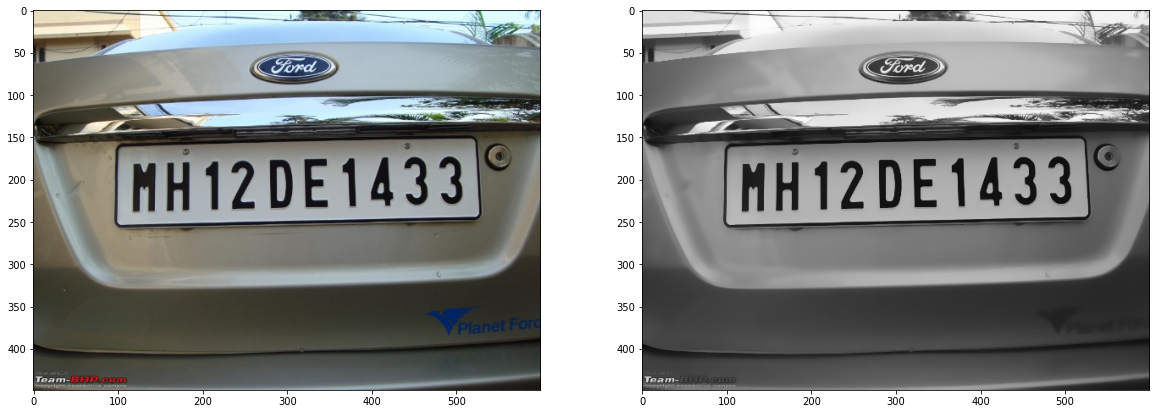

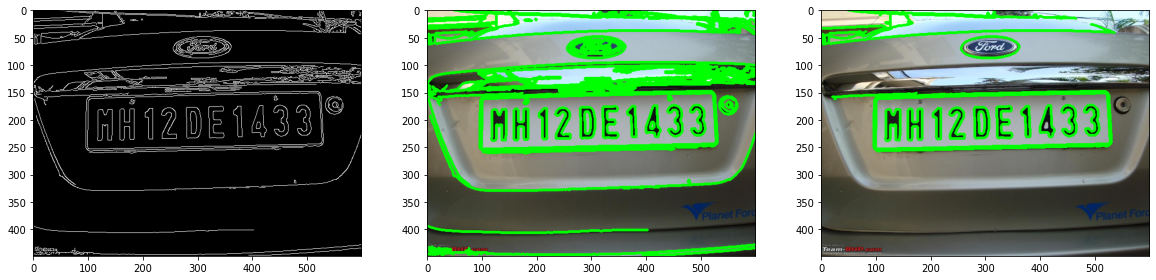

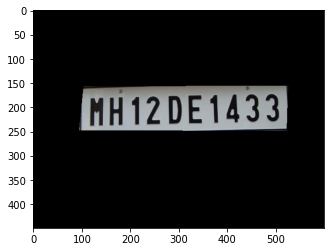

In [129]:
img, gray = readImage('auto.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
# finalPlate = rotatePlate(img, carPlate)
# dominantColourRGB = findDominantColour(croppedCarPlate)
# msg = checkIfPlatesAreYellow(dominantColourRGB)
# print(msg)
# readTextFromPlates(finalPlate)

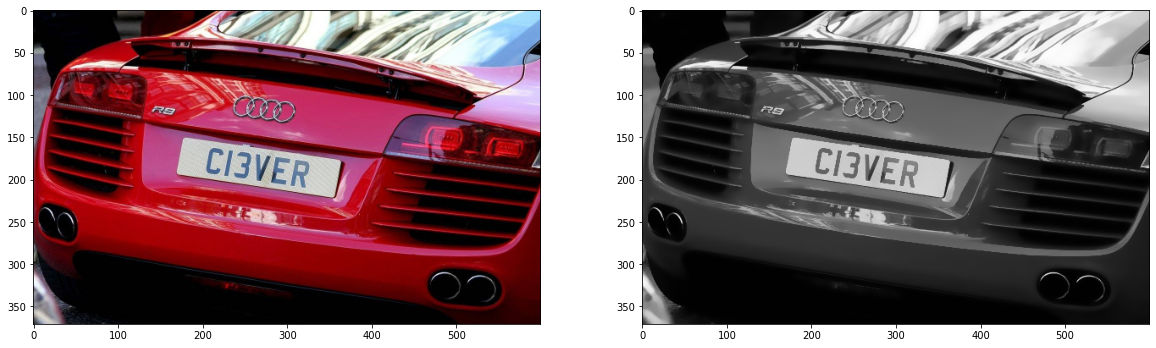

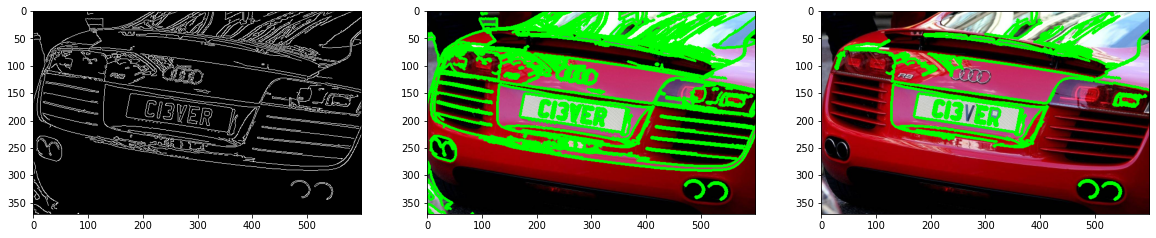

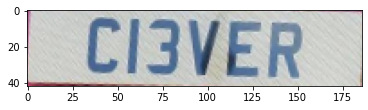

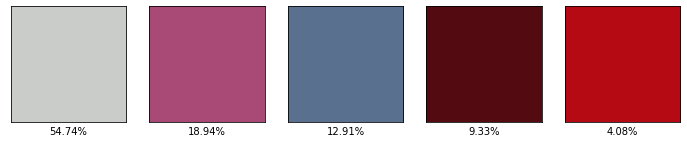

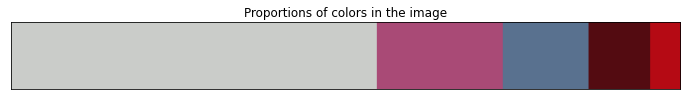

None
Detected license plate Number is: CIBVER



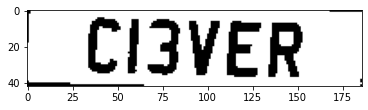

In [120]:
img, gray = readImage('auto3.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)

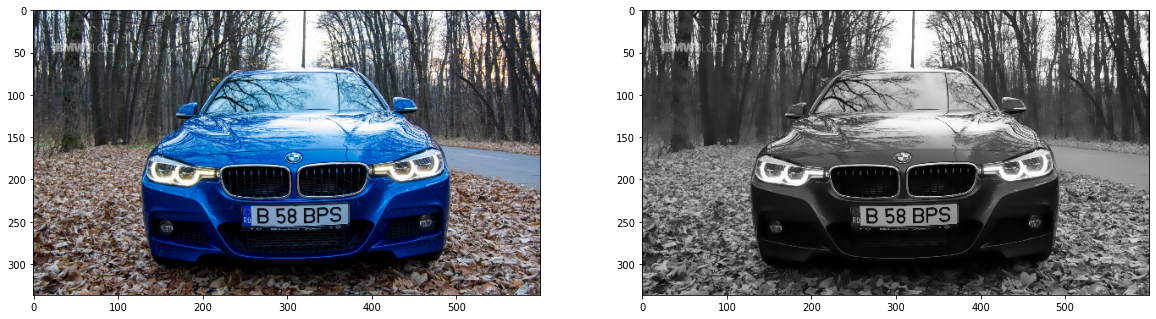

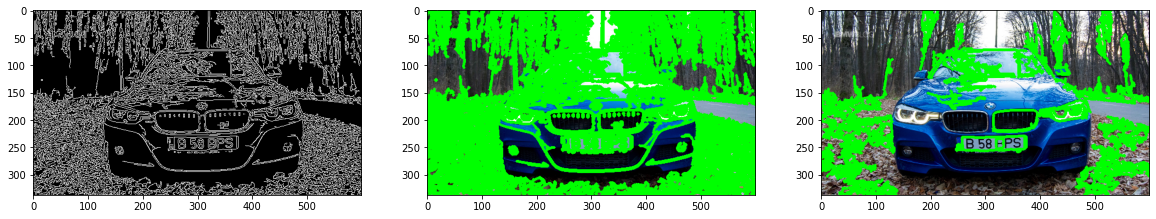

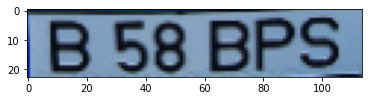

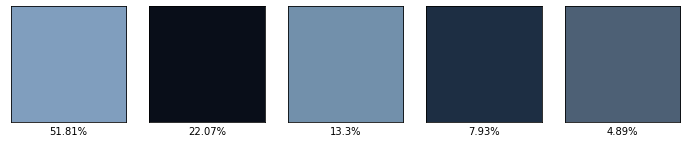

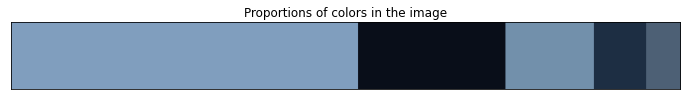

None
Detected license plate Number is: B58 BPS



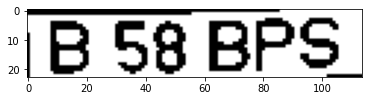

In [121]:
img, gray = readImage('auto5.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)

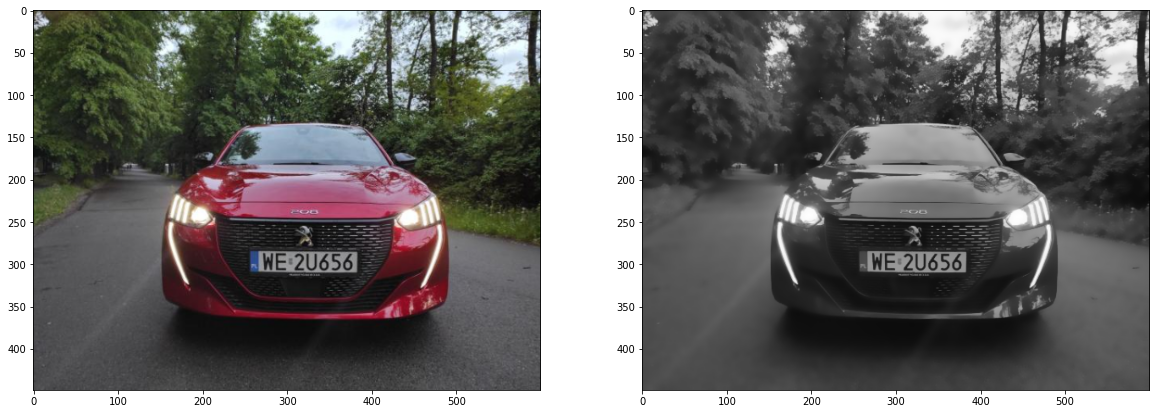

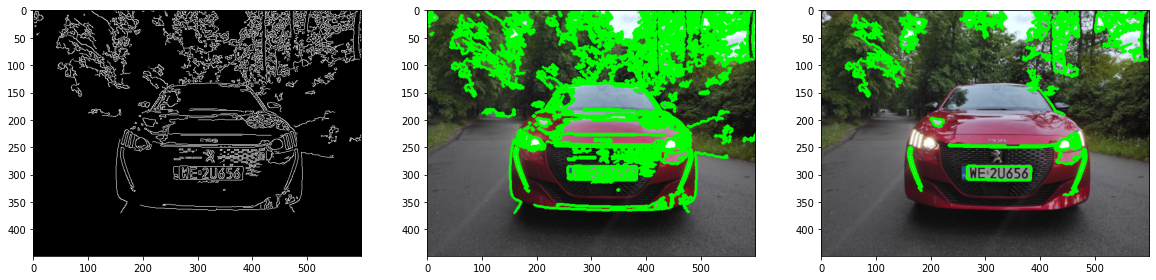

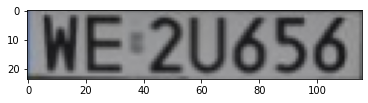

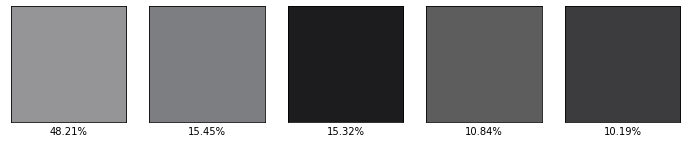

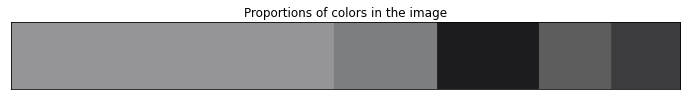

None
Detected license plate Number is: WE:2U656



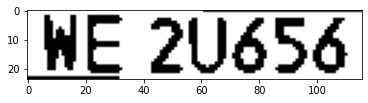

In [122]:
img, gray = readImage('auto6.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)


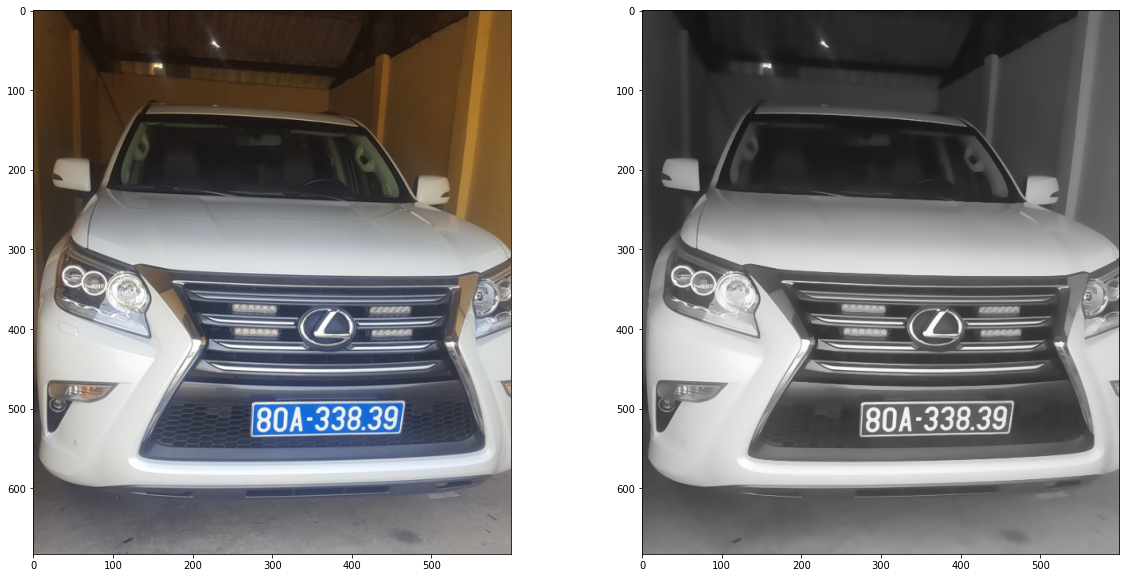

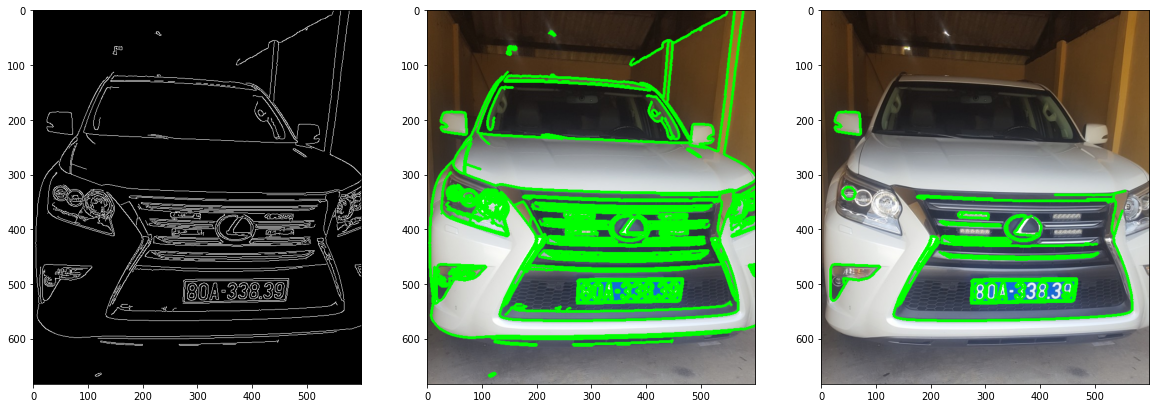

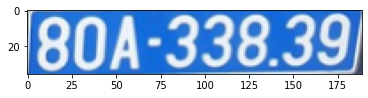

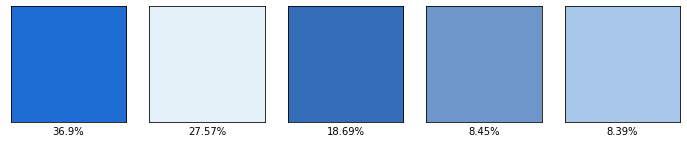

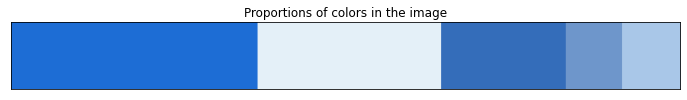

As the car plate background is blue, it may be from China, Yemen, Peru
Detected license plate Number is: '80A-338.39,



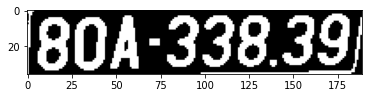

In [123]:
img, gray = readImage('auto9.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)

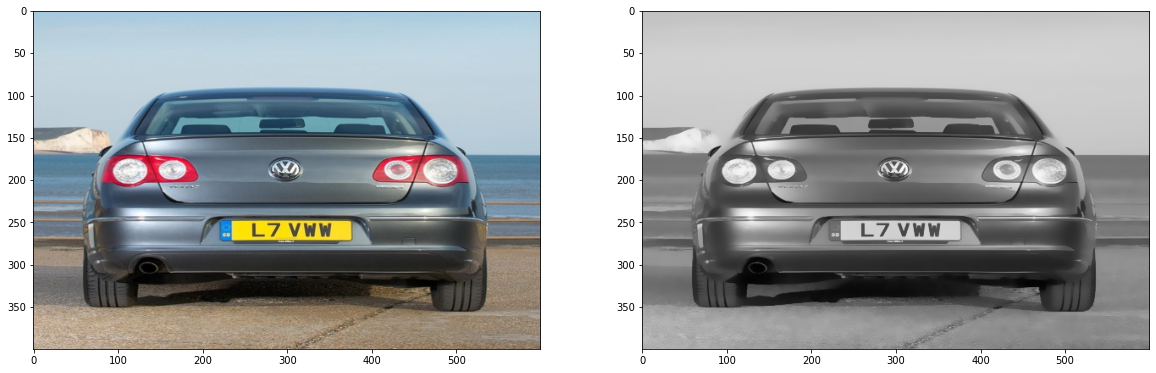

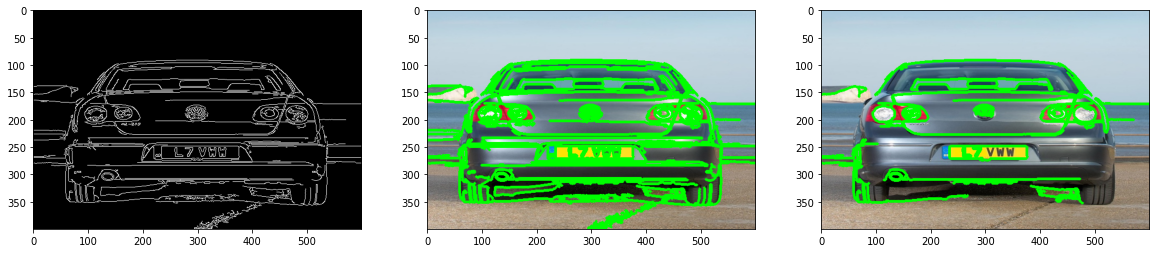

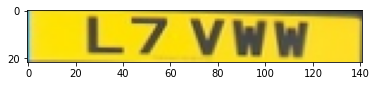

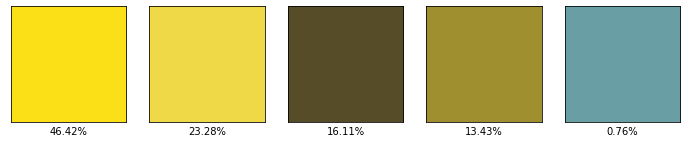

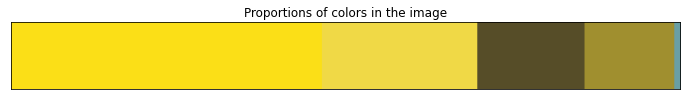

[251 223  23]
As the car plate background is yellow, it may be from countries like: 
EUROPE: Luxembourg, Netherlands, United Kingdom, also Denmark and Hungary but only for commercial vehicles. 
ASIA: North Korea, Oman, Israel 
AFRICA: Namibia Tanzania, Zimbabwe, Gabon, Suriname
Detected license plate Number is:  LZ7VWW



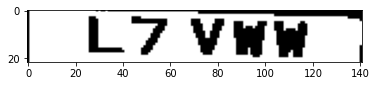

In [97]:
img, gray = readImage('auto10.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)

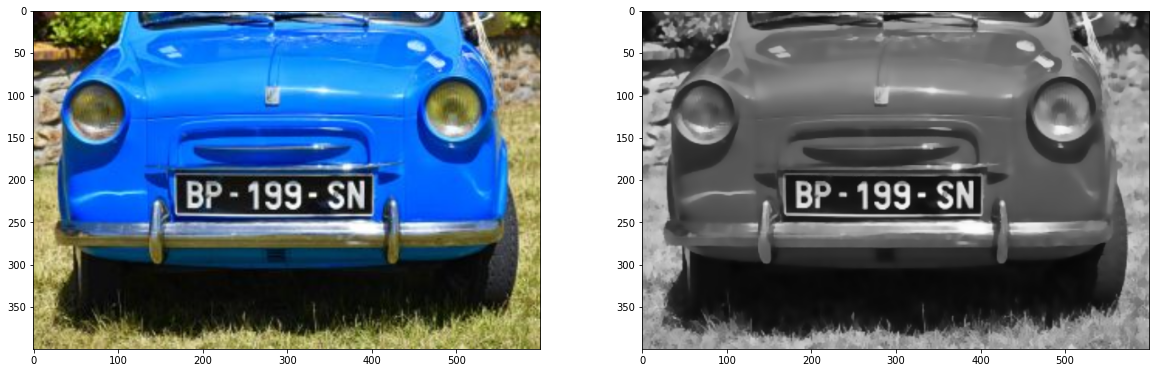

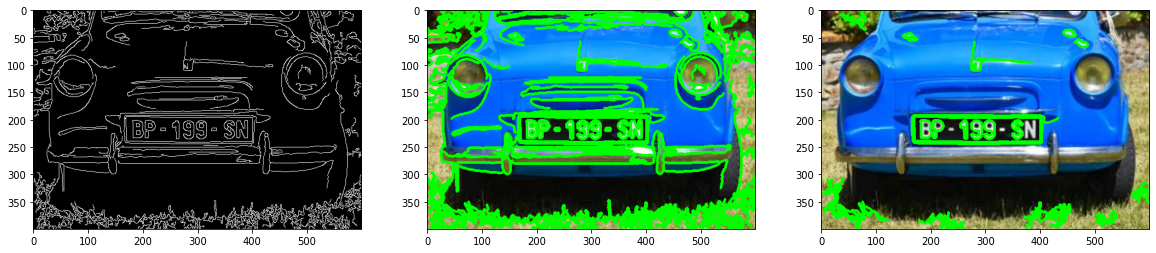

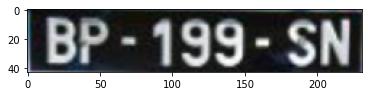

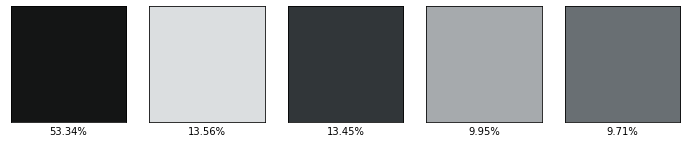

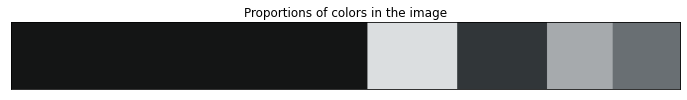

[20 21 21]
As the car plate background is black, it may be from 
ASIA: North Yemen, Pakistan, Papua New Guinea, Singapore, South Yemen, Timor Leste, Vietnam, Brunei, Myanmar, India, Indonesia, Malaysia 
AFRICA: Nigeria, Sierra Leone, Somalia, Tanganyika, Angola, Egypt, Eritrea, Ethiopia, Libya 
AMERICAS: Argentina, Guyana
Detected license plate Number is: BP-199-SN



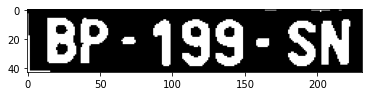

In [102]:
img, gray = readImage('auto17.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)

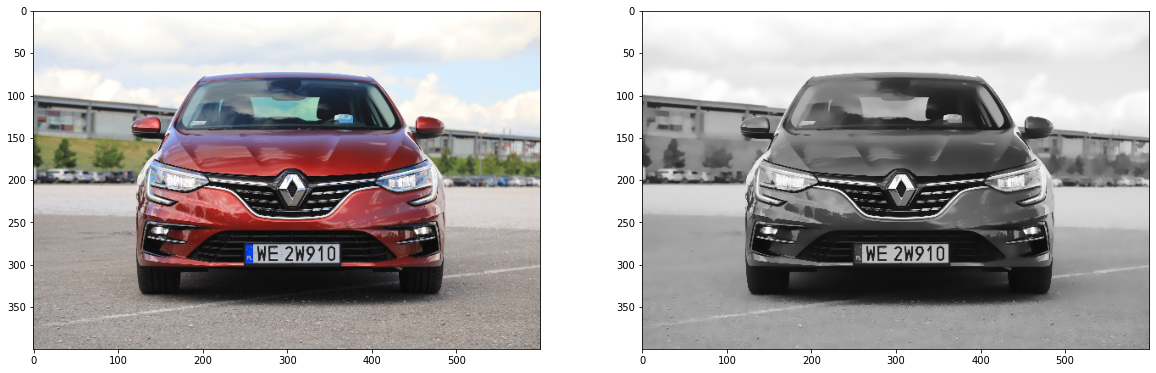

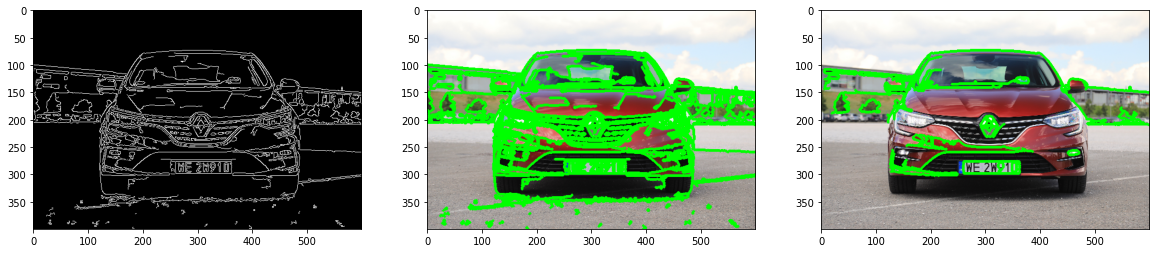

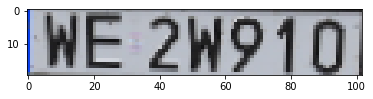

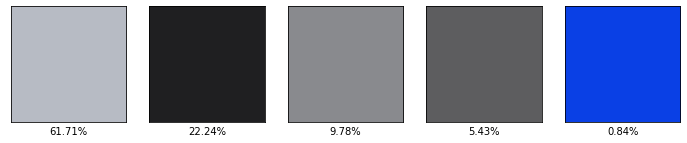

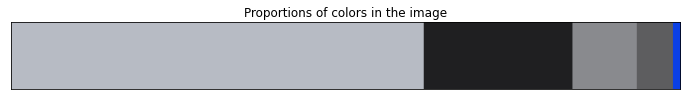

[183 187 196]
As we ruled out most of other possible plate colours, plates probably white or they represent some other, extraordinery kind of places
Detected license plate Number is: WE 2W910)



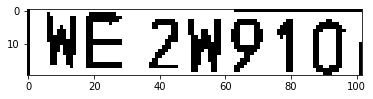

In [103]:
img, gray = readImage('auto18.jpg')
bestContours = findContours(img, gray)
carPlate = findCarPlate(img, bestContours)
croppedCarPlate = extractCarPlate(img, carPlate)
finalPlate = rotatePlate(img, carPlate)
dominantColourRGB = findDominantColour(croppedCarPlate)
msg = checkIfPlatesAreYellow(dominantColourRGB)
print(msg)
readTextFromPlates(finalPlate)